# Visión artificial aplicada a la industria
### Intecol SAS
## Clase 6: Extracción de características

In [2]:
import matplotlib.pyplot as plt
def plot(imagen,color='white',title=None,cmapa='gray',pic = False,subplot  = (1,1,1),vmin = 0, vmax = 255):
    if pic == True:
        plt.figure(figsize=(15,8))
    plt.subplot(subplot[0],subplot[1],subplot[2])
    plt.axis('off')
    plt.imshow(imagen,cmap = cmapa,vmin = vmin, vmax = vmax)
    plt.title(title,color = color)

## Esqueletización
El esqueleto de una imagen es la base de los objetos que la conforman, donde cada uno de ellos tiene la característica esencial de tener solo un pixel de grosor y cuya posición está definida en la mitad del objeto. Se logra utilizando el algoritmo de adelgazamiento iterativamente, hasta que la imagen se componga de un objeto con grosor de 1 pixel. 

Para esto tenemos que empezar por definir varias propiedades:

### Conectividad

Un pixel está conectado a otro si éste está en su contacto directo. Hay dos tipos de conectividad, a 4 o a 8, como se muestra en la imagen.

![](images/conect.png)

Dependiendo del tipo de conectividad se define la cantidad de objetos que hay en una imagen. En la imagen de abajo se pueden tener 4 objetos o 1 solo, dependiendo del tipo de conectividad usada.

![](images/reg.png)

Según esto, podemos definir los componentes conectados como aquellos conjuntos de pixeles que tengan conectividad entre ellos. Además de esto, un pixel en la frontera de un objeto está definido como aquel pixel que tenga algún vecino no conectado al objeto.

![](images/frontera.png)

Para realizar la esqueletización de un objeto es fundamental entonces realizar el proceso de adelgazamiento, el cual consiste en remover iterativamente los pixeles de las fronteras, usando la convolución con elementos estructurales de este estilo, donde los pixeles que tengan la vecindad igual a la del kernel son los pixeles removidos. Esta operación es conocida como *adelgazamiento*

![](images/struct.png)

Estos elementos estructurales son en base a $B^1$ y $B^2$, rotados secuencialmenete 90°. El uso consecutivo de estos kernels da como resultado la esqueletización de un objeto, el cual se da como finalizado cuando todos los objetos en la imagen tengan solamente un pixel de grosor.

![](images/ske.png)







Esto también se puede hacer con un conjunto de operaciones de erosión y dilatación, en el siguiente algoritmo:

### 1. Crear un esqueleto vacío.
### 2. Realizar la apertura de la imagen original.
### 3. Guardar la diferencia de la imagen original y la apertura en *temp*.
### 4. Definir el esqueleto como la unión entre el esqueleto y *temp*.
### 5. Erosionar la imagen original.
### 6. Si esta erosión da un valor diferente a la imagen $\vec{ 0}$ repetir los pasos 2 a 5.

*Este algoritmo no garantiza objetos conectados!*

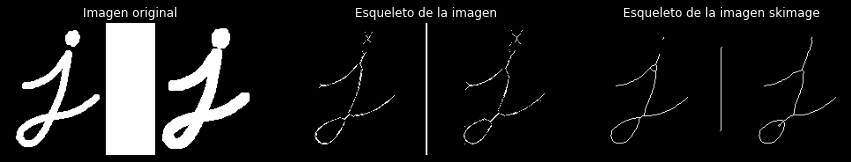

In [3]:
# Import the necessary libraries
import cv2
import numpy as np
from skimage.morphology import skeletonize


def esqueletizar(image):

    plt.figure(figsize=(15,15))
    plot(image,subplot=(1,3,1),title="Imagen original")
    
    #Convertir la imagen a binaria
    ret,img = cv2.threshold(image, 127, 255, 0)

    # 1. Crear un esqueleto vacío 
    size = np.size(img)
    skel = np.zeros(img.shape, np.uint8)

    # Usar elemento estructurante en forma de cruz
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))

    # Repetir pasos 2 a 5
    while True:
        # 2. Realizar apertura de la imagen
        open = cv2.morphologyEx(img, cv2.MORPH_OPEN, element)
        # 3. Guardar la diferencia entre la original y la apertura en temp
        temp = cv2.subtract(img, open)
        # 4. Definir el esqueleto como la unión entre el esqueleto y temp
        skel = cv2.bitwise_or(skel,temp)
        #5. Erosionar la imagen original y guardarla
        eroded = cv2.erode(img, element)
        img = eroded.copy()
        # 6. Si la erosión da un valor diferente a la imagen cero, repetir
        if cv2.countNonZero(img)==0:
            break

    # Displaying the final skeleton
    plot(skel,subplot=(1,3,2),title = "Esqueleto de la imagen")


    #Usando Skimage necesitamos convertir la imagen a 0 y 1
    ret,img = cv2.threshold(image, 127, 1, 0)
    sk = skeletonize(img)
    plot(sk,subplot=(1,3,3),title = "Esqueleto de la imagen skimage",vmax = 1)



image = cv2.imread('images/a.png', 0)
esqueletizar(image)

# Extracción de características

Después de lograr la separación de la imagen en objetos binarios, el objetivo siguiente es lograr la caracterización de cada uno de ellos con el objetivo de llegar a una clasificación adecuada de cada uno. Para esto se tienen como herramientas diferentes características de los objetos, las cuales nos permiten lograr a identificar ciertos patrones en ellos que mostraremos a continuación.

## Contornos

Esta operación permite extraer la información de todos los puntos continuos al rededor de la superficie de un objeto. De estos resultados podemos extraer varias características, nombradas a continuación.

### Bounding box
Para cada objeto, es el rectángulo más pequeño en el cual es posible contener el objeto. A partir de esta característica es posible la extracción de otras que mostraremos más adelante. En el ejemplo se muestra como es posible encontrar las regiones límite de cada objeto con el uso de la función `cv2.findContours`, la cual recibe una imagen de entrada y entrega un arreglo de arreglos, donde cada item contiene el centro de cada objeto, su ancho y su alto. Esto permite dibujar facilmente el bounding box.

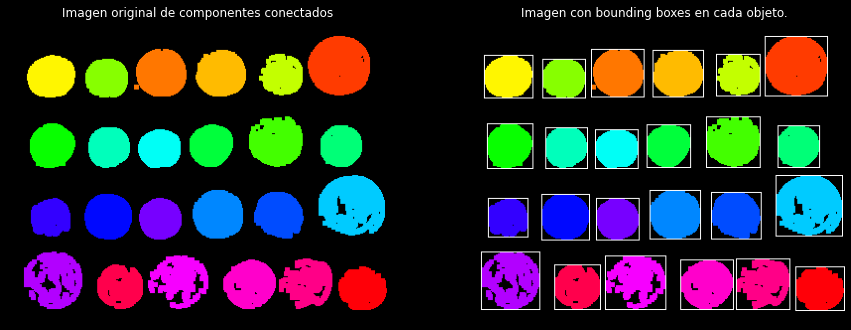

In [4]:
from skimage import data 

imagen =  data.coins()
kernel = np.ones((5,5),np.uint8)

_,imagen = cv2.threshold(imagen,150,255,cv2.THRESH_BINARY)
imagen = cv2.dilate(imagen,kernel)
image = np.copy(imagen)

ret, labels = cv2.connectedComponents(image)
label_hue = np.uint8(179 * labels / np.max(labels))
blank_ch = 255 * np.ones_like(label_hue)
labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2RGB)

labeled_img[label_hue == 0] = 0
lab = np.copy(labeled_img)
contours, hierarchy = cv2.findContours(image,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)  
cont=[]

for c in contours:
    # get the bounding rect
    x, y, w, h = cv2.boundingRect(c)
    if(w>30):
        cont.append(c)
        cv2.rectangle(labeled_img, (x, y), (x+w, y+h), (255, 255, 255), 1)

plt.figure(figsize=(15,15))
plot(lab,subplot=(1,2,1),title = "Imagen original de componentes conectados")



De esta característica podemos sacar dos valores esenciales como son el alto y el ancho de cada objeto y con ello filtrar dependiendo de lo que se esté trabajando.

## Momentos de una imagen

Son el análogo de los momentos físicos de objeto. Está definido por 

$
    M_{ij} = \sum\limits_x\sum\limits_y x^iy^j I(x,y),
$

donde $x,y$ son las filas y columnas e $I(x,y)$ es la intensidad del pixel en la fila $x$ y columna $y$. Con esta definición tenemos que el centro de masa (o centroide) de un objeto está dado por 

$
    c_x = \dfrac{M_{01}}{M_{00}}\qquad c_y =\dfrac{M_{10}}{M_{00}},
$

donde $M_{00}= \sum\sum I(x,y)$ es la definición del área del objeto y $M_{01}  = \sum\sum xI(x,y)$, $M_{10}  = \sum\sum yI(x,y)$ son los momentos al rededor del eje $x,y$ respectivamente. Podemos extraer esto de los contornos de los objetos como se muestra a continuación.

Area (M00) = 1449
cx = 124
cy = 205


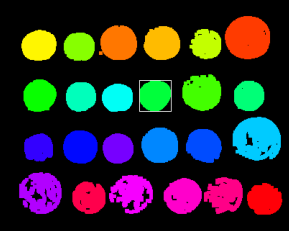

In [5]:
def momentos(objeto,cont = cont,lab = lab): 
    lab_m = np.copy(lab)
    
    cnt  = cont[objeto]
    moments = cv2.moments(cnt)
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(lab_m, (x, y), (x+w, y+h), (255, 255, 255), 1)
    return lab_m,moments

lab_m,moments = momentos(15)
m00 = moments['m00']
m01 = moments['m01']
m10 = moments['m10']
cx = m01/m00
cy = m10/m00
print(f'Area (M00) = {m00:.0f}')
print(f'cx = {cx:.0f}')
print(f'cy = {cy:.0f}')
plot(lab_m)

### Área $A$
Esta característica como su nombre lo indica mide el área en pixeles que ocupa cierto objeto.

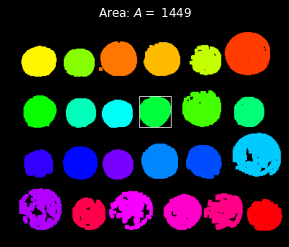

In [6]:
def area(objeto,cont=cont,lab = lab):
    lab_a = np.copy(lab)
    
    cnt  = cont[objeto]
    a = cv2.contourArea(cnt)
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(lab_a, (x, y), (x+w, y+h), (255, 255, 255), 1)
    return lab_a, a

labels_area,a = area(15)
plot(labels_area,title = f'Area: $A = $ {a:.0f}')

### Perímetro $p$
Mide el perímetro de un objeto en pixeles. Para esto usamos el contorno del objeto y sumamos sus pixeles.

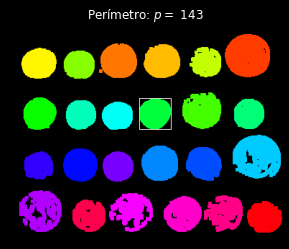

In [7]:
def perimetro(objeto):
    lab_p = np.copy(lab)
    
    cnt  = cont[objeto]
    p = cv2.arcLength(cnt,True)
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(lab_p, (x, y), (x+w, y+h), (255, 255, 255), 1)
    return lab_p, p

lab_p,p = perimetro(15)
plot(lab_p,title = f'Perímetro: $p =$ {p:.0f}')

### Circularidad
Este valor nos indica que tan circular es un objeto. Está dado por

$
    c = \dfrac{p^2}{2\pi A}.
$

Cuando $c=1$ tenemos un círculo perfecto.

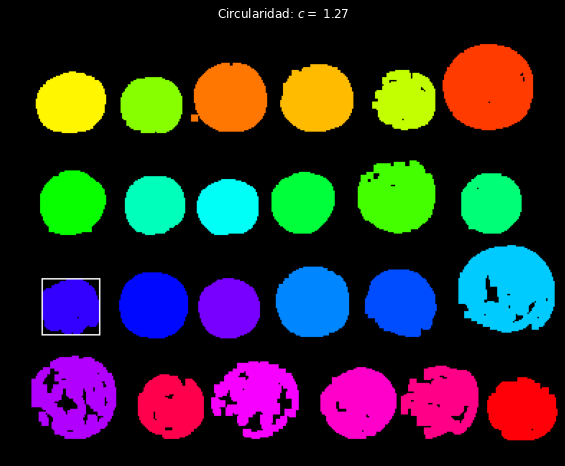

In [8]:
img, a = area(7)
_, p = perimetro(7)
c = p**2/(4*np.pi*a)
plot(img,title = f'Circularidad: $c =$ {c:.2f}',pic = True)

## Uso de `cv2.connectedComponentsWithStats` para extracción de características

Con el uso de esta herramienta tenemos acceso a las siguientes características de cada objeto:

### - Coordenada más a la izquierda de las columnas
### - Coordenada más a la derecha de las filas
### - Alto del objeto
### - Ancho del objeto
### - Area del objeto
### - Centroide del objeto en x
### - Centroide del objeto en y


In [9]:
ret,labels,stats,centroids = cv2.connectedComponentsWithStats(image, cv2.CV_32S)
objeto = 7
a = 4
x = 0
y = 1
w = 2
h = 3
print(f'Objeto: {objeto}')
print(f'Coordenada más a la izquierda: {stats[objeto,x]}')
print(f'Coordenada más arriba: {stats[objeto,y]}')
print(f'Ancho: {stats[objeto,w]}')
print(f'Alto: {stats[objeto,h]}')
print(f'Area: {stats[objeto,a]}')
print(f'Centroide x: {centroids[objeto,x]}')
print(f'Centroide y: {centroids[objeto,y]}')

Objeto: 7
Coordenada más a la izquierda: 244
Coordenada más arriba: 95
Ancho: 54
Alto: 51
Area: 2174
Centroide x: 270.9857405703772
Centroide y: 119.8620055197792


# Ejercicio
Separar los objetos de la siguiente imagen en dos catergorías, rectángulos y círculos.

![](images/ejercicio.png)

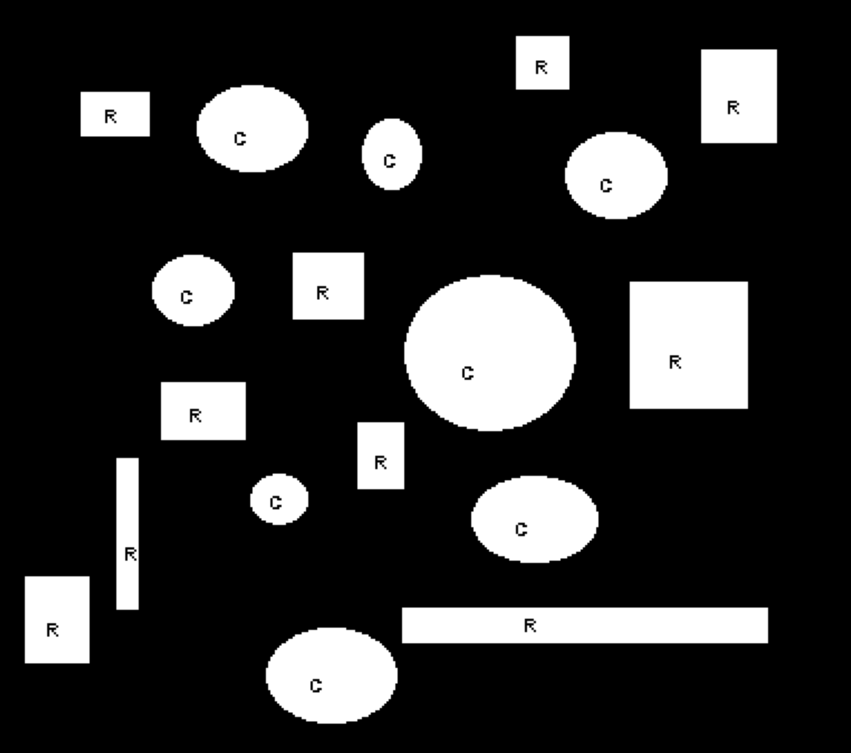

In [14]:
i = cv2.imread('images/ejercicio.png',0)
i = cv2.bitwise_not(i)

cn, _ = cv2.findContours(i,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
for c in cn:
    a = cv2.contourArea(c)
    p = cv2.arcLength(c,True)
    ci = p**2/(4*np.pi*a)
    x, y, w, h = cv2.boundingRect(c)
    font = cv2.FONT_HERSHEY_SIMPLEX
    if ci > 1.2:
        # cv2.rectangle(i_c, (x, y), (x+w, y+h), 0,-1)
        i=cv2.putText(i,'R', (int(x+w/3), int(y+h/1.5)), font,.25,0,1)
    else:
        i=cv2.putText(i,'C', (int(x+w/3), int(y+h/1.5)), font,.25,0,1)
        # cv2.rectangle(i_r, (x, y), (x+w, y+h), 0,-1)

plt.figure(figsize=(15,15))
plot(i)
